<h1>Deriving MHWs using a fixed baseline</h1>

**Dataset used here**: Global Ocean OSTIA Sea Surface Temperature and Sea Ice Reprocessed (OSTIA) (Dataset ID: METOFFICE-GLO-SST-L4-REP-OBS-SST)

*Worsfold, M.; Good, S.; Atkinson, C.; Embury, O. Presenting a Long-Term, Reprocessed Dataset of Global Sea Surface Temperature Produced Using the OSTIA System. Remote Sens. 2024, 16, 3358. https://doi.org/10.3390/rs16183358*

Available at: https://data.marine.copernicus.eu/product/SST_GLO_SST_L4_REP_OBSERVATIONS_010_011/services

In [3]:
### Imports 

# ! pip install copernicusmarine
import copernicusmarine
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import math
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter
from scipy.stats import circmean
from collections import deque

c:\Users\annas\miniforge3\envs\cmems_env_py3.9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
### Remotely login and access the data from CMEMS

copernicusmarine.login()
datasetID = 'METOFFICE-GLO-SST-L4-REP-OBS-SST'
DS = copernicusmarine.open_dataset(dataset_id = datasetID)

In [ ]:
### Crop to area of interest - choose coordinates

lon_min = -44
lon_max = -30
lat_min = -59
lat_max = -49

lon = slice(lon_min, lon_max)   
lat = slice(lat_min, lon_max) 
cropped_DS = DS.analysed_sst.sel(longitude = lon, latitude = lat)

raw_data = cropped_DS.to_dataframe()

**Derive Background Climatology and SST Time Series**

In [ ]:
# Spatially average every day within the background period (e.g. 01/01/1990-31/12/2009)
dayrange = pd.date_range('1990-01-01', '2009-12-31', freq='D')
raw_data['time'] = pd.to_datetime(raw_data['time'])
avgs = raw_data.groupby('time')['analysed_sst'].mean().reindex(dayrange, fill_value=None)
dict = {'date': dayrange, 'avg_t': avgs}  
bg_timeseries = pd.DataFrame(dict)

# Remove 29th February
bg_timeseries['year'] = bg_timeseries['date'].dt.year
bg_timeseries['month'] = bg_timeseries['date'].dt.month
bg_timeseries['day'] = bg_timeseries['date'].dt.day
bg_timeseries = bg_timeseries.loc[~((bg_timeseries['month'] == 2) & (bg_timeseries['day'] == 29))]

# Apply smoothing filter, create new dataframe
day = pd.date_range('1990-01-01', '2009-12-31', freq='D')
day_no_feb29 = day[~((day.month == 2) & (day.day == 29))]
sigma = 30
smoothed_avgs = gaussian_filter(bg_timeseries['avg_t'].to_list(), sigma=sigma)
dict2 = {'date': day_no_feb29, 'avg_t': smoothed_avgs} 
smooth_bg_timeseries = pd.DataFrame(dict2)

smooth_bg_timeseries['year'] = smooth_bg_timeseries['date'].dt.year

# Split into column for each year in background climatology range (e.g. 1990-2009)
year = np.arange(1990, 2010)
dict3 = {}
for i in range(len(year)):
    sst = smooth_bg_timeseries.query(f"year == {year[i]}")['avg_t'].values
    dict3[f'sst_{year[i]}'] = sst
bg = pd.DataFrame(dict3)

# Average across each calendar day + find 90th percentile
bg['mean'] = bg.mean(axis=1)
bg['Q90'] = bg.apply(lambda row: np.percentile(row.drop('mean'), 90), axis=1)

bg.head(3)

,sst_1990,sst_1991,sst_1992,sst_1993,sst_1994,sst_1995,sst_1996,sst_1997,sst_1998,sst_1999,...,sst_2002,sst_2003,sst_2004,sst_2005,sst_2006,sst_2007,sst_2008,sst_2009,mean,Q90
0,276.320083,275.843249,274.282973,275.297740,275.216614,274.781945,274.637361,275.578171,274.235452,275.630449,...,275.590547,275.014056,275.439322,275.652871,275.176861,275.335638,274.944990,275.676205,275.239047,275.692909
1,276.320547,275.868752,274.311945,275.323101,275.240589,274.810958,274.668281,275.608250,274.260943,275.658279,...,275.624592,275.042510,275.453962,275.680196,275.208735,275.365166,274.967477,275.700532,275.264423,275.717354
2,276.321474,275.894084,274.340672,275.348020,275.264351,274.839783,274.699159,275.637956,274.286463,275.685871,...,275.658297,275.070865,275.468279,275.707325,275.240530,275.394434,274.989773,275.724652,275.289633,275.741595


In [6]:
### Organise spatially-averaged SST into dataframe for all years 1982-2021 (columns = years, rows = day of year)

year_start = 1982
year_end   = 2022

# Spatially average every day
grouped_DoY = raw_data.groupby('time')
average_day_sst = grouped_DoY.mean()
average_day_sst = average_day_sst.reset_index()

# Remove 29th February and create new dataframe
sst_groupby_yr = {}
for i in range(year_start, year_end): 
    t_evolution = average_day_sst[(average_day_sst['time'] >= f"{i}-01-01") & (average_day_sst['time'] <= f"{i}-12-31")]
    t_evolution = t_evolution[t_evolution['time'] != f"{i}-02-29"]
    sst_groupby_yr[f'sst_{i}'] = t_evolution['analysed_sst'].reset_index()['analysed_sst']

year_col_sst = pd.DataFrame.from_dict(sst_groupby_yr) 

year_col_sst.head(3)

,sst_1982,sst_1983,sst_1984,sst_1985,sst_1986,sst_1987,sst_1988,sst_1989,sst_1990,sst_1991,...,sst_2012,sst_2013,sst_2014,sst_2015,sst_2016,sst_2017,sst_2018,sst_2019,sst_2020,sst_2021
0,275.509388,275.116746,275.590762,275.144941,275.949796,274.948702,274.901659,276.170681,276.384196,275.552101,...,275.244208,275.015419,275.581263,275.659493,275.159563,275.136618,276.094499,275.542823,275.753661,275.582345
1,275.479889,275.205151,275.650879,275.177072,275.814150,274.977561,274.999319,276.180727,275.947596,275.560599,...,275.268085,275.111717,275.509214,275.648771,275.410611,274.998702,276.165500,275.599586,275.782310,275.661135
2,275.533451,275.257666,275.686955,274.931624,276.214313,274.955721,274.932078,276.099912,275.851903,275.739540,...,275.444196,275.163940,275.531519,275.599016,275.473009,274.976315,276.174907,275.657992,275.754639,275.832229


**Visualise Background Climatology & SST Example**

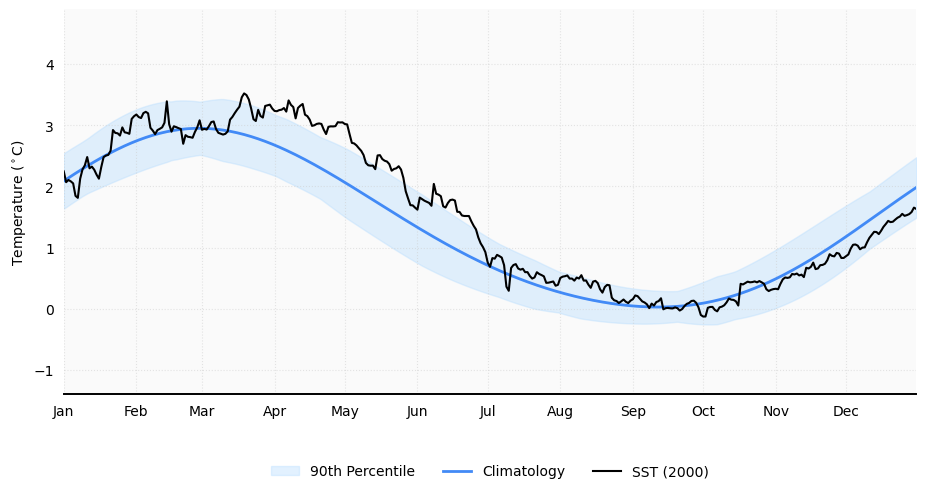

In [29]:
bg['mean_C'] = bg['mean']-273.15
bg['Q90_C'] = bg['Q90'] - bg['mean']
times = pd.date_range('1990-01-01', '1990-12-31', freq='D')

plt.figure(figsize=(11,5))

ax= plt.gca()

ax.set_facecolor('#FAFAFA')
ax.spines[['top', 'right', 'left']].set_visible(False)
ax.spines[['bottom']].set_linewidth(1.4)
plt.tick_params(left = False)
plt.tick_params(bottom = False)
plt.grid(linestyle='dotted', color='#ccc', zorder=1, alpha=0.5)

plt.fill_between(times, bg['mean_C'], bg['Q90_C']+bg['mean_C'], zorder=1, alpha=0.4,  color='#B7DDFF', label='90th Percentile')
plt.fill_between(times, bg['mean_C'], bg['mean_C']-bg['Q90_C'], zorder=1, alpha=0.4,  color='#B7DDFF')
plt.plot(times, bg['mean']-273.15, color='#428af6', linewidth=2, zorder=2, label='Climatology')
plt.plot(times, year_col_sst['sst_2000']-273.15, color='k', zorder=2, label='SST (2000)')

plt.ylabel('Temperature ($^\circ$C)')

plt.ylim(-1.4, 4.9)
plt.xlim(pd.to_datetime('1990-01-01'), pd.to_datetime('1990-12-31'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
plt.show()

**Identifying MHW Events**

In [ ]:
### Find the anomalies - how much each day exceeds the 90th percentile (set to NaN if it doesn't exceed)

# Find the differences between raw data and background climatology
sstdiff_gb_yr = {}

for i in range(year_start, year_end):
    diff = year_col_sst[f'sst_{i}'] - bg['mean']
    sstdiff_gb_yr[f'diff_{i}'] = diff

difference = pd.DataFrame.from_dict(sstdiff_gb_yr)     
difference['mean'] = bg['mean'] - 273.15
difference['Q90'] = bg['Q90'] - bg['mean']
times = pd.date_range('1982-01-01', '1982-12-31', freq='D')  
difference['date'] = times

# Select where difference is positive (warm events) and set rest equal to NaN 
# Arrange into a dataframe, columns = year, rows = day of year
# Cell values = degrees above the 90th percentile 
years = np.arange(year_start, year_end)

dict4 = {}
for j in range(len(years)):
    std_diff = []
    for i in range(len(difference['date'])):
        if difference[f'diff_{years[j]}'].iloc[i] >= 0:
            diff = difference[f'diff_{years[j]}'].iloc[i] - difference['Q90'].iloc[i]
            if diff > 0:
                std_diff.append(diff)
            else:
                std_diff.append(np.nan)
        # Find where differences are negative (cold events), set to NaN
        else:
            std_diff.append(np.nan)
    dict4[f'std_diff{years[j]}'] = std_diff

times = pd.date_range('1982-01-01', '1982-12-31', freq='D')  
dict4['date'] = times

# Create dataframe, columns = year, rows = day of year
# Only cells that exceed the 90th percentile have a value, the rest = NaN
anoms = pd.DataFrame(dict4) 

anoms.head(3)

,std_diff1982,std_diff1983,std_diff1984,std_diff1985,std_diff1986,std_diff1987,std_diff1988,std_diff1989,std_diff1990,std_diff1991,...,std_diff2013,std_diff2014,std_diff2015,std_diff2016,std_diff2017,std_diff2018,std_diff2019,std_diff2020,std_diff2021,date
0,NaN,NaN,NaN,NaN,0.256887,NaN,NaN,0.477772,0.691287,NaN,...,NaN,NaN,NaN,NaN,NaN,0.401590,NaN,0.060752,NaN,1982-01-01
1,NaN,NaN,NaN,NaN,0.096796,NaN,NaN,0.463373,0.230242,NaN,...,NaN,NaN,NaN,NaN,NaN,0.448146,NaN,0.064956,NaN,1982-01-02
2,NaN,NaN,NaN,NaN,0.472718,NaN,NaN,0.358317,0.110308,NaN,...,NaN,NaN,NaN,NaN,NaN,0.433311,NaN,0.013044,0.090634,1982-01-03


In [30]:
### Identify the MHW events per year

# Go through anoms dataframe and record lengths of each period that exceeds (length of consecutive cells with values in)
start_d = []
end_d = []

for i in range(len(years)):
    yrlist = list(anoms[f'std_diff{years[i]}'])

    yrlistp = deque([np.nan if x < 0 else x for x in yrlist])
    yrlistp.appendleft(np.nan)

    indvals = []
    for m in range(len(yrlistp)):
        if np.isnan(yrlistp[m-1]):
            if not np.isnan(yrlistp[m]):
                indvals.append(m)

    start_day = []
    end_day = []

    # Only count events that are 5 days or longer
    # Record the start and end dates of each event

    for k in range(len(indvals)):
        arr_here = []
        for j in range(len(yrlistp)-indvals[k]):
            if not np.isnan(yrlistp[indvals[k]+j]):
                arr_here.append(yrlistp[indvals[k]+j])
            if np.isnan(yrlistp[indvals[k]+j]):
                break
        if len(arr_here) > 4:
            start_day.append(indvals[k]-1)
            end_day.append(indvals[k]+len(arr_here)-1)
    start_d.append(start_day)
    end_d.append(end_day)

# Create dataframe, each row is a year. 
# The columns startdate and enddate hold lists of each event within each year
dict = {'year': years, 'startdate': start_d, 'enddate': end_d}
start_end = pd.DataFrame.from_dict(dict)

###

# Find the break between each event and merge those that are < 5 days apart
breaks = []
for i in range(len(years)):
    starts = start_end.loc[start_end['year'] == years[i], 'startdate'].values[0]
    ends = start_end.loc[start_end['year'] == years[i], 'enddate'].values[0]
    br = []
    for j in range(len(starts)-1):
        diff = starts[j+1] - ends[j]
        br.append(diff)
    breaks.append(br)

start_end['breaks'] = breaks

new_start = []
new_end = []

for m in range(len(years)):
    Breaks = start_end.loc[start_end['year'] == years[m], 'breaks'].values[0]
    starts = start_end.loc[start_end['year'] == years[m], 'startdate'].values[0]
    ends = start_end.loc[start_end['year'] == years[m], 'enddate'].values[0]

    for k in range(len(Breaks)):
        if Breaks[k] < 5:
            ends[k] = np.nan
            starts[k+1] = np.nan

    new_start.append([x for x in starts if not (isinstance(x, float) and math.isnan(x))])
    new_end.append([x for x in ends if not (isinstance(x, float) and math.isnan(x))])

dict = {}
dict['year'] = start_end['year']
dict['starts'] = new_start
dict['ends'] = new_end

MHWevents = pd.DataFrame.from_dict(dict)

In [31]:
### Find the intensities etc. of each event

all_max_int = []
all_avg_int = []
all_duration = []
all_peaks = []
year_here = []

for i in range(len(years)):
    max_i = []
    avg_i = []
    dur = []
    year_Here = []
    peak_day = []
    for j in range(len(MHWevents.loc[MHWevents['year'] == years[i], 'starts'].values[0])):
        temp_excess = []
        start = MHWevents.loc[MHWevents['year'] == years[i], 'starts'].values[0][j]
        end = MHWevents.loc[MHWevents['year'] == years[i], 'ends'].values[0][j]
        for m in range(start, end):
            temp_excess.append(anoms[f'std_diff{years[i]}'].iloc[m])
        max_i.append(np.nanmax(temp_excess))
        avg_i.append(np.nanmean(temp_excess))
        dur.append(len(temp_excess))
        peak_day.append(np.nanargmax(temp_excess)+MHWevents.loc[MHWevents['year'] == years[i], 'starts'].values[0][j])
        year_Here.append(years[i])

    all_max_int.append(max_i)
    all_avg_int.append(avg_i)
    all_duration.append(dur)
    all_peaks.append(peak_day)
    year_here.append(year_Here)

MHWevents['max_i'] = all_max_int
MHWevents['avg_i'] = all_avg_int
MHWevents['duration'] = all_duration
MHWevents['peak_day'] = all_peaks
MHWevents['year_here'] = year_here

MHWevents.head(3)

,year,starts,ends,max_i,avg_i,duration,peak_day,year_here
0,1982,"[8, 20, 160, 204, 219, 235, 298]","[14, 111, 166, 210, 225, 269, 313]","[0.08300836033430414, 0.8272150689707587, 0.11...","[0.06590376738545463, 0.4498575016935602, 0.06...","[6, 91, 6, 6, 6, 34, 15]","[10, 75, 161, 208, 223, 253, 302]","[1982, 1982, 1982, 1982, 1982, 1982, 1982]"
1,1983,"[12, 46, 239]","[26, 71, 259]","[0.4985340741658888, 0.7750332490263645, 0.142...","[0.19201931422621368, 0.3581763665348126, 0.06...","[14, 25, 20]","[22, 62, 244]","[1983, 1983, 1983]"
2,1984,"[7, 32, 88]","[14, 80, 102]","[0.10290357546466566, 0.7658315849561177, 0.14...","[0.06419417067684208, 0.3545288755543293, 0.04...","[7, 48, 14]","[12, 52, 88]","[1984, 1984, 1984]"


**Categorise events** Using *Hobday et al, 2018* categorisation scheme for intensity and duration

In [32]:
### Defining event intensities

# Multiples of 90th percentile
difference['Q902'] = difference['Q90']*2
difference['Q903'] = difference['Q90']*3
difference['Q904'] = difference['Q90']*4

# Find which range the peak intensity lies in
peak_intensity = []

for i in range(len(years)):
    peak_here = []
    for j in range(len(MHWevents['peak_day'].iloc[i])):
        peak_ints = (MHWevents['max_i']).iloc[i][j]

        peak_int = (MHWevents['peak_day']).iloc[i][j]
        q901 = difference['Q90'].iloc[peak_int]
        q902 = difference['Q902'].iloc[peak_int]
        q903 = difference['Q903'].iloc[peak_int]
        q904 = difference['Q904'].iloc[peak_int]

        if 0 <= peak_ints < q901:
            peak_here.append('Moderate')
        if q901 <= peak_ints < q902:
            peak_here.append('Strong')
        if q902 <= peak_ints < q903:
            peak_here.append('Severe')
        if q903 <= peak_ints:
            peak_here.append('Extreme')

    peak_intensity.append(peak_here)

MHWevents['intensity_cat'] = peak_intensity

In [37]:
### Defining event durations

durationss = []

for i in range(len(years)):
    peak_here = []
    for j in range(len(MHWevents['duration'].iloc[i])):
        peak_ints = (MHWevents['duration']).iloc[i][j]

        if 0 <= peak_ints < 10:
            peak_here.append('Brief')
        if 10 <= peak_ints < 30:
            peak_here.append('Intermediate')
        if 30 <= peak_ints < 50:
            peak_here.append('Extended')
        if 50 <= peak_ints:
            peak_here.append('Prolonged')

    durationss.append(peak_here)

MHWevents['duration_cat'] = durationss

**Plotting Fig.7 and Fig.8**
*Frequency of MHW events per year, coloured by intensity / duration*

In [ ]:
# Get list of lists for intensity / duration categories (list for each year) 

categories = []

for i in range(0,40):
    ind = i*1 + 1
    yr_here = []
    for j in range(i*1, ind):
        yr_here.append(MHWevents['year'].iloc[j])

    yr_here_cats = []

    for k in yr_here:
        category = MHWevents[MHWevents['year'] == k]['intensity_cat'].tolist()  # <------ Change for intensity / duration here 
        yr_here_cats.append(category)

    all_events = sum(sum(yr_here_cats, []),[])
    categories.append(all_events)

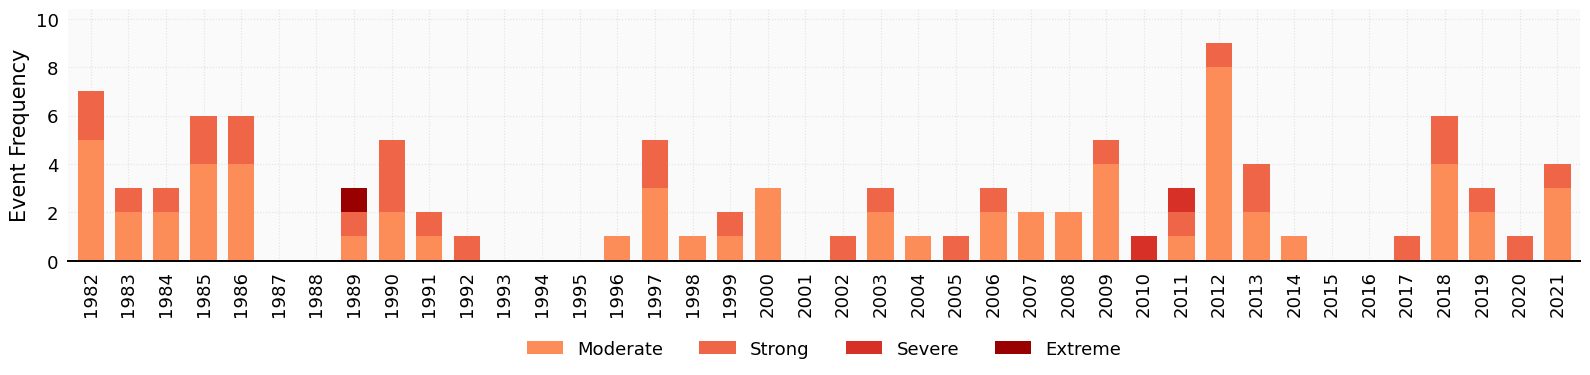

In [ ]:
# Select intensity or duration to plot
#options = ['Brief', 'Intermedieate', 'Extended', 'Prolonged'] # Categories for Duration
options = ["Moderate", "Strong", "Severe", "Extreme"] # Categories for Intensity
#colors = ["#eef5fc", "#7eb1fe", "#428af6", "#1c3f75"] # Colours for Duration
colors = ['#fc8d59','#ef6548','#d73027', '#990000'] # Colours for Intensity

cat_opts = pd.DataFrame([{opt: row.count(opt) for opt in options} for row in categories])

ax = cat_opts.plot(kind='bar', stacked=True, color=colors, figsize=(16, 4), zorder=2, width=0.7)

ax.set_facecolor('#FAFAFA')
ax.spines[['top', 'right', 'left']].set_visible(False)
ax.spines[['bottom']].set_linewidth(1.4)

custom_labels = years
ax.set_xticks(range(len(custom_labels)))
ax.set_xticklabels(custom_labels, rotation=90) 
ax.set_ylim(0,10.4)
ax.get_legend().remove()

plt.tick_params(left = False)
plt.tick_params(bottom = False)
plt.grid(linestyle='dotted', color='#ccc', zorder=1, alpha=0.5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('Event Frequency', fontsize=15)

plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.25), ncol=4, frameon=False, fontsize=13)

plt.tight_layout()
plt.show()

**Plotting Fig.10**
*MHW events displayed as bars where length equates to the event’s duration*

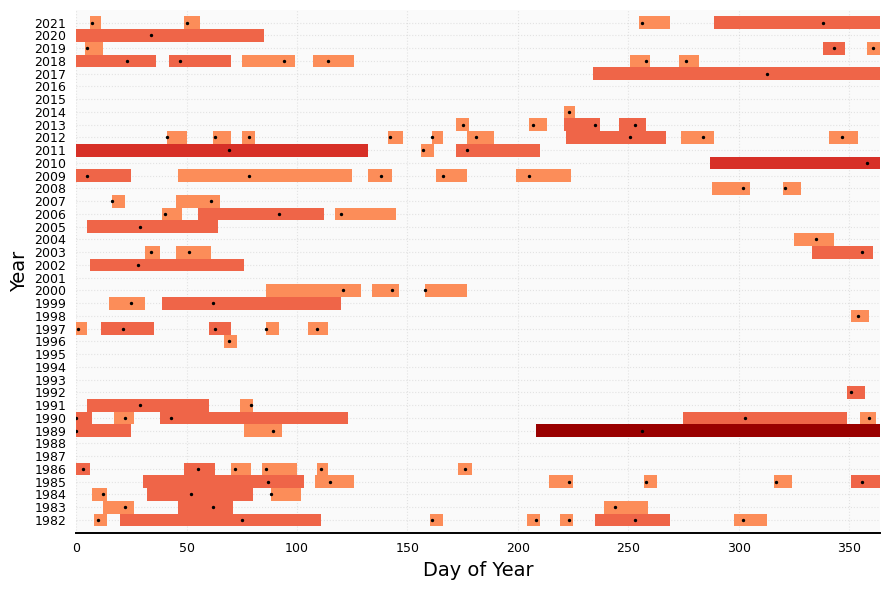

In [ ]:
# Intensity colours
colors = ['#990000','#d73027','#ef6548', '#fc8d59']

peakdayp = [item for sublist in MHWevents['peak_day'] for item in sublist]
yr = np.array([item for sublist in MHWevents['year_here'] for item in sublist])
startday = np.array([item for sublist in MHWevents['starts'] for item in sublist])
duration = np.array([item for sublist in MHWevents['duration'] for item in sublist])

plt.figure(figsize=(9,6))
plt.grid(linestyle='dotted', color='#ccc', zorder=1, alpha=0.5)
plt.xlim(0,364)
plt.ylim(year_start - 1, year_end)
plt.yticks(years, fontsize=9)
plt.xticks(fontsize=9)
plt.xlabel('Day of Year', fontsize=14)
plt.ylabel('Year', fontsize=14)
plt.tick_params(left = False)
plt.tick_params(bottom = False)

### STYLING ###

ax = plt.gca()
ax.set_facecolor('#FAFAFA')
ax.spines[['top', 'right', 'left']].set_visible(False)
ax.spines[['bottom']].set_linewidth(1.4)

###

# Plot each event as a shaded rectangle
for i in range(len(years)):
    y = years[i]
    starts = MHWevents['starts'].loc[i]
    dur = MHWevents['duration'].loc[i]
    inten = MHWevents['avg_i'].loc[i]

    for m in range(len(dur)):
        y_min = y - 0.5
        x_min = starts[m]
        y_len = 1
        x_len = dur[m]
        intensity = inten[m]

        if MHWevents['intensity_cat'].loc[i][m] == 'Moderate':
            colour = colors[3]
        if MHWevents['intensity_cat'].loc[i][m] == 'Strong':
            colour = colors[2]
        if MHWevents['intensity_cat'].loc[i][m] == 'Severe':
            colour = colors[1]
        if MHWevents['intensity_cat'].loc[i][m] == 'Extreme':
            colour = colors[0]

        ax.add_patch(Rectangle((x_min, y_min), x_len, y_len, fc =colour,lw = 0, zorder=5))

# Peak days
plt.scatter(peakdayp, yr, c='k', s=2, zorder=10)

plt.tight_layout()
plt.show()

**References**

Hobday A.J., Oliver E.C.J., Sen Gupta A., Benthuysen J.A., Burrows M.T., et al. (2018). *Categorizing and naming marine heatwaves*. Oceanography 31(2):162–73